# Introduction

The [Santander Cycle Hire Scheme](https://console.cloud.google.com/marketplace/product/greater-london-authority/london-bicycles) dataset was queried in the [queries.sql](queries.sql) file to obtain the average daily bike change at each station for 2022. This information can be leveraged to plan the manual relocation of these bikes, which is especially important for stations with large net daily influxes or outfluxes. We will develop an algorithm to plan the manual rebalacing of the stations. For simplicity's sake, we will assume:
1. The vans used to move the bikes between stations can only carry 10 bikes at once: assuming relocations involving fewer than 10 bikes aren't cost-effective
2. The relocation of bikes is always done at 12:00 am (after all daily bike trips are completed)
3. The daily bike changes throughout 2023 are equal to the 2022-average daily bike changes
4. The distance between any two stations will be the Euclidean distance between the station coordinates
5. At the start of time, bikes are distributed among the stations in proportion to the total number of docks

Below, we will outline the parameters for bike relocation, in order of decreasing importance:
1. The stations should never become completely full or empty of bikes: stations predicted to get full or empty will be targeted for bike relocation.
2. An efficiency measure was created inspired by the rebalancing strategy designed by Florian et. al (2013). A station requiring relocation will exchange bikes with another station trying to maximise the following:  
$${Trip\:efficiency=\frac{Priority\:of\:station\:not\:needing\:immediate\:rebalacing}{(Distance\:between\:the\:two\:stations)^2}}$$

### Example

Check the [Example](#Example-1) section for a simple case depicting the relocation algorithm.

### References

Florian H, Avram C, Pop M, Radu D, Aștilean A. Resources Relocation Support Strategy Based on a Modified Genetic Algorithm for Bike-Sharing Systems. Mathematics. 2023; 11(8):1816. https://doi.org/10.3390/math11081816



In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate

In [2]:
flux_station = pd.read_csv('flux-station-2022.csv')

In [3]:
flux_station.head()

station_name  avg_chg_bicycles
0  Abbey Orchard Street, Westminster          6.038781
1      Abbotsbury Road, Holland Park         -1.534626
2    Aberdeen Place, St. John's Wood         -2.587258
3           Aberfeldy Street, Poplar         -0.002770
4        Abingdon Green, Westminster          5.110803

In [4]:
flux_station.avg_chg_bicycles.sum()

# The -0.0027 observed is due to the one 2022/2023 trip we allowed previously [-0.0027 * (365 - 4) = 0.97]

-0.0027700831024901618

In [5]:
station = pd.read_csv('station.csv', usecols = ['name', 'longitude', 'latitude', 'bikes_count', 'docks_count', 'nbEmptyDocks'])
station.head()

latitude  longitude                             name  bikes_count  \
0  51.498898  -0.100441  Borough Road, Elephant & Castle           40   
1  51.476149  -0.123258        Teversham Lane, Stockwell           39   
2  51.521776  -0.068856      Buxton Street 1, Shoreditch           39   
3  51.539329  -0.074285      Haggerston Road, Haggerston           36   
4  51.525120  -0.015578                 Devons Road, Bow           37   

   docks_count  nbEmptyDocks  
0           41             0  
1           39             0  
2           41             1  
3           37             1  
4           39             2

In [6]:
station_flux = flux_station.merge(station, left_on='station_name', right_on='name').drop('name', axis=1)
station_flux.head()

station_name  avg_chg_bicycles   latitude  longitude  \
0  Abbey Orchard Street, Westminster          6.038781  51.498126  -0.132102   
1      Abbotsbury Road, Holland Park         -1.534626  51.501391  -0.205991   
2    Aberdeen Place, St. John's Wood         -2.587258  51.524826  -0.176268   
3           Aberfeldy Street, Poplar         -0.002770  51.513548  -0.005659   
4        Abingdon Green, Westminster          5.110803  51.497640  -0.125972   

   bikes_count  docks_count  nbEmptyDocks  
0           26           29             2  
1           12           24            12  
2            3           18            15  
3            3           16            13  
4            8           20            11

In [7]:
station_flux[station_flux.docks_count - station_flux.bikes_count != station_flux.nbEmptyDocks]

# We can see that 193 stations do not have the expected value for the number of empty docks. Further investigation into this matter might be
#  worthwhile; however, for the sake of simplicity, we will overlook the 'nbEmptyDocks' column and assume the information in 'bikes_count' and 
# 'docks_count' is correct.

station_name  avg_chg_bicycles   latitude  \
0    Abbey Orchard Street, Westminster          6.038781  51.498126   
4          Abingdon Green, Westminster          5.110803  51.497640   
8           Addison Road, Holland Park         -0.487535  51.504199   
9               Aintree Street, Fulham         -1.252078  51.481021   
10    Albany Street, The Regent's Park         -4.368421  51.528302   
..                                 ...               ...        ...   
782          William IV Street, Strand          6.650970  51.509462   
784            Windsor Terrace, Hoxton         -4.445983  51.529154   
789  Wormwood Street, Liverpool Street          0.759003  51.516155   
790         Worship Street, Shoreditch          3.504155  51.521668   
792          Wright's Lane, Kensington          1.997230  51.500398   

     longitude  bikes_count  docks_count  nbEmptyDocks  
0    -0.132102           26           29             2  
4    -0.125972            8           20            11  
8    -0.210941            4           26            21  
9    -0.209973           23           24             0  
10   -0.144466           17           27             9  
..         ...          ...          ...           ...  
782  -0.124749            9           26            16  
784  -0.093422           23           24             0  
789  -0.082422            8           16             7  
790  -0.079609            9           51            41  
792  -0.193068           15           37            21  

[193 rows x 7 columns]

In [8]:
station_flux.drop('nbEmptyDocks', axis=1, inplace=True)

In [9]:
station_flux.bikes_count.sum()

# The total bikes figure (10967) is different to the one obtained directly from the BigQuery dataset (23427). This may be due to bike 
# replacements during 2022 or due to the addition of bikes since the original station data was last updated; it may be worth investigating 
# further into this. We will use the bike total calculated from the original station data in our analysis.

10967

In [10]:
bike_total = station_flux.bikes_count.sum()
station_total = station_flux.docks_count.sum()

station_flux.bikes_count = (bike_total / station_total) * station_flux.docks_count

station_flux.head()

station_name  avg_chg_bicycles   latitude  longitude  \
0  Abbey Orchard Street, Westminster          6.038781  51.498126  -0.132102   
1      Abbotsbury Road, Holland Park         -1.534626  51.501391  -0.205991   
2    Aberdeen Place, St. John's Wood         -2.587258  51.524826  -0.176268   
3           Aberfeldy Street, Poplar         -0.002770  51.513548  -0.005659   
4        Abingdon Green, Westminster          5.110803  51.497640  -0.125972   

   bikes_count  docks_count  
0    15.116112           29  
1    12.509886           24  
2     9.382414           18  
3     8.339924           16  
4    10.424905           20

In [11]:
station_flux['priority'] = np.where(station_flux.avg_chg_bicycles == 0, 0, np.nan)  

# Column indicating the relocation priority given to each station

def priority_calc():
    station_flux.loc[station_flux.avg_chg_bicycles > 0, 'priority'] = (station_flux.bikes_count + 
                                                                       station_flux.avg_chg_bicycles) / station_flux.docks_count - 0.521245

    station_flux.loc[station_flux.avg_chg_bicycles < 0, 'priority'] = 0.521245 - (station_flux.bikes_count + 
                                                                                  station_flux.avg_chg_bicycles) / station_flux.docks_count 

priority_calc()
station_flux.head()

station_name  avg_chg_bicycles   latitude  longitude  \
0  Abbey Orchard Street, Westminster          6.038781  51.498126  -0.132102   
1      Abbotsbury Road, Holland Park         -1.534626  51.501391  -0.205991   
2    Aberdeen Place, St. John's Wood         -2.587258  51.524826  -0.176268   
3           Aberfeldy Street, Poplar         -0.002770  51.513548  -0.005659   
4        Abingdon Green, Westminster          5.110803  51.497640  -0.125972   

   bikes_count  docks_count  priority  
0    15.116112           29  0.208234  
1    12.509886           24  0.063943  
2     9.382414           18  0.143736  
3     8.339924           16  0.000173  
4    10.424905           20  0.255540

In [12]:
station_flux['day'] = 0  # Column indicating the day number of our simulation
station_flux['coordinate'] = list(map(Point, station_flux.longitude, station_flux.latitude))

station_flux.head()

station_name  avg_chg_bicycles   latitude  longitude  \
0  Abbey Orchard Street, Westminster          6.038781  51.498126  -0.132102   
1      Abbotsbury Road, Holland Park         -1.534626  51.501391  -0.205991   
2    Aberdeen Place, St. John's Wood         -2.587258  51.524826  -0.176268   
3           Aberfeldy Street, Poplar         -0.002770  51.513548  -0.005659   
4        Abingdon Green, Westminster          5.110803  51.497640  -0.125972   

   bikes_count  docks_count  priority  day                        coordinate  
0    15.116112           29  0.208234    0  POINT (-0.132102166 51.49812559)  
1    12.509886           24  0.063943    0       POINT (-0.205991 51.501391)  
2     9.382414           18  0.143736    0       POINT (-0.176268 51.524826)  
3     8.339924           16  0.000173    0       POINT (-0.005659 51.513548)  
4    10.424905           20  0.255540    0      POINT (-0.12597218 51.49764)

In [13]:
def color_map_color(value, cmap_name='Blues', vmin=0, vmax=0.5):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm(value))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = mpl.colors.rgb2hex(rgb)
    return color

plt.rcParams['figure.figsize'] = [20, 10]

In [14]:
def map_station_flux():
    fig, ax = plt.subplots()
    ax.scatter(station_flux.longitude, station_flux.latitude, c='w')

    for i, (bikes, docks, priority) in enumerate(zip(station_flux.bikes_count, station_flux.docks_count, station_flux.priority)):
        ax.annotate(f'{bikes:.0f}/{docks:.0f}', (station_flux.longitude[i], station_flux.latitude[i]), c=color_map_color(priority))

    # for xi, yi, txt in zip(longitude, latitude, flux_station.avg_chg_bicycles):
    #     ax.scatter(xi, yi, marker=f'${txt}$', s=200, edgecolors='black')

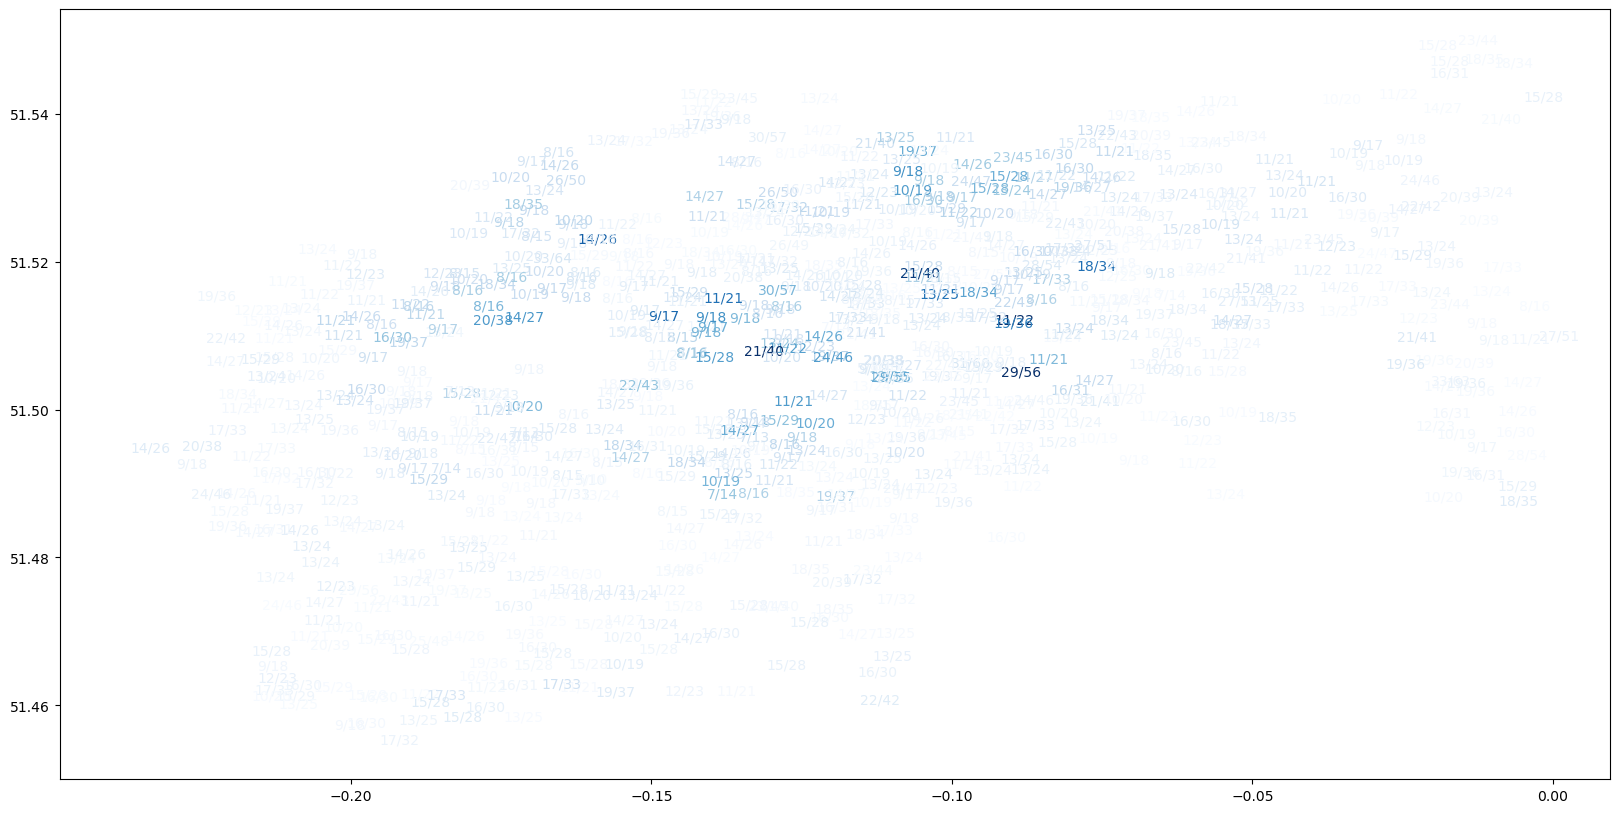

In [15]:
map_station_flux()

# We can see the distribtion of the stations and how full they are.

In [16]:
def next_day():
    station_flux.bikes_count = station_flux.bikes_count + station_flux.avg_chg_bicycles
    priority_calc()
    station_flux.day += 1

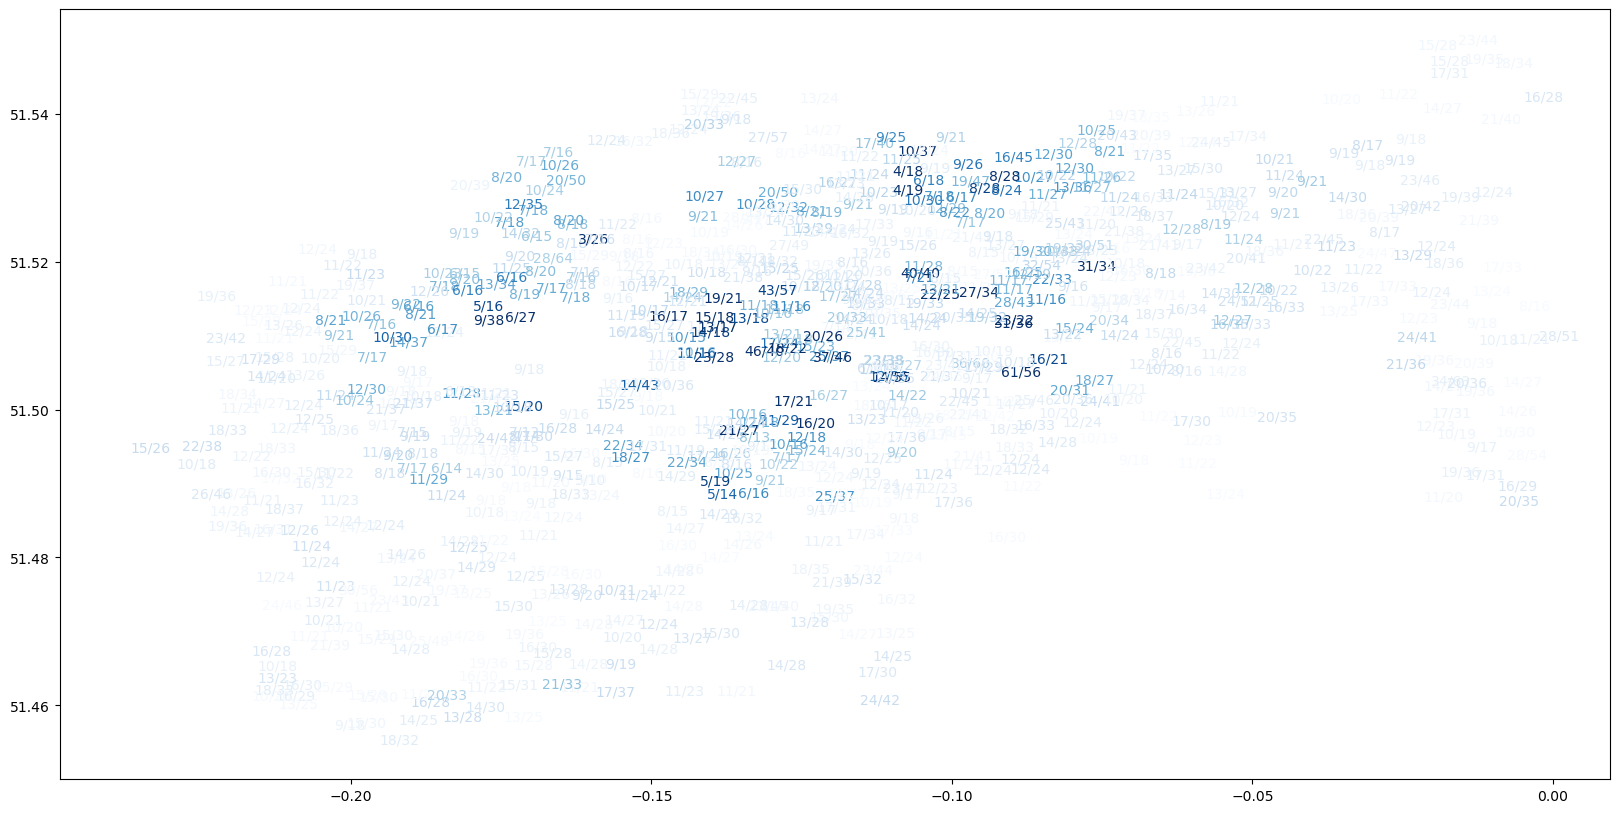

In [17]:
next_day()
map_station_flux()

# After one day, the distribution of bikes changes. A station with a '61/56' bike-to-dock ratio can be spotted roughly at the center-right 
# of the map. It is required to relocate bikes from this station to stop it from 'overflowing' (in reality, the cycle hirers 
# would have to look for alternative stations with free docks).

In [18]:
def previous_day():
    station_flux.bikes_count = station_flux.bikes_count - station_flux.avg_chg_bicycles
    priority_calc()
    station_flux.day -= 1

previous_day()
station_flux.head()

# We will 'go back' one day to relocate the bikes from stations expected to reach their maximum capacity (or, on the contrary, stations
# predicted to fully empty).

station_name  avg_chg_bicycles   latitude  longitude  \
0  Abbey Orchard Street, Westminster          6.038781  51.498126  -0.132102   
1      Abbotsbury Road, Holland Park         -1.534626  51.501391  -0.205991   
2    Aberdeen Place, St. John's Wood         -2.587258  51.524826  -0.176268   
3           Aberfeldy Street, Poplar         -0.002770  51.513548  -0.005659   
4        Abingdon Green, Westminster          5.110803  51.497640  -0.125972   

   bikes_count  docks_count  priority  day                        coordinate  
0    15.116112           29  0.208234    0  POINT (-0.132102166 51.49812559)  
1    12.509886           24  0.063943    0       POINT (-0.205991 51.501391)  
2     9.382414           18  0.143736    0       POINT (-0.176268 51.524826)  
3     8.339924           16  0.000173    0       POINT (-0.005659 51.513548)  
4    10.424905           20  0.255540    0      POINT (-0.12597218 51.49764)

In [19]:
p0_name = 'Start point'
p0 = Point(station_flux.longitude.mean(), station_flux.latitude.mean())
p0_priority = 0

p0_idx = pd.Index([-1])

# Before constructing our relocation algorithm it is necessary to specify a starting point for the van carrying the bikes.

In [20]:
p1_candidate = station_flux[(station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) | 
                            (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)]

p1_candidate.head()

# We can see these stations will 'overflow' with bikes the next day if we do not relocate some of them. {For example, "Hop Exchange, The
# Borough" is expected to get an influx of 32 bikes after one day, exceeding the number of docks available [32 > (56 - 29 =) 27]}.

station_name  avg_chg_bicycles   latitude  longitude  \
354        Hop Exchange, The Borough         32.130194  51.504628  -0.091774   
555             Queen Street 1, Bank         11.914127  51.511553  -0.092940   
655  St. James's Square, St. James's         25.180055  51.507425  -0.134621   

     bikes_count  docks_count  priority  day                        coordinate  
354    29.189734           56  0.573754    0  POINT (-0.091773776 51.50462759)  
555    11.467395           22  0.541551    0    POINT (-0.0929401 51.51155322)  
655    20.849810           40  0.629502    0  POINT (-0.134621209 51.50742485)

In [21]:
relocation = pd.DataFrame(columns=['start_station_name', 'start_station_coordinate', 'start_station_priority',
                                   'end_station_name', 'end_station_coordinate', 'end_station_priority', 'distance', 'num_bikes',
                                   'x', 'y', 'dx', 'dy'])

# The relocation DataFrame will store the trips to be taken by the van redistributing the bikes.

In [22]:
option = pd.DataFrame(columns=['p0p1_distance', 'overall_priority', 'p1_name', 'p1_coordinate', 'p1_priority',
                               'p2_name', 'p2_coordinate', 'p2_priority', 'p1p2_distance', 'num_bikes'])

for p1_idx in p1_candidate.index:

    p1 = station_flux.loc[p1_idx, 'coordinate']

    if station_flux.loc[p1_idx, 'avg_chg_bicycles'] > 0:

        p2_candidate = station_flux[(station_flux.avg_chg_bicycles < 0) & (station_flux.docks_count - station_flux.bikes_count >= 10)]

        p2_priority =  0.521245 - (p2_candidate.bikes_count + p2_candidate.avg_chg_bicycles) / p2_candidate.docks_count
            
        p1p2_distance = p1.distance(p2_candidate.coordinate)

        efficiency_min_sub = (p2_priority - p2_priority.min() + 1e-5) / (p1p2_distance + 1e-5)

        p2_idx = efficiency_min_sub.idxmax()
        
        p2 = station_flux.loc[p2_idx, 'coordinate']

        p0p1_distance_val = p0.distance(p1)
        p1_name = station_flux.loc[p1_idx, 'station_name']
        p1_coordinate = p1
        p1_priority = station_flux.loc[p1_idx, 'priority']
        p2_name = station_flux.loc[p2_idx, 'station_name']
        p2_coordinate = p2
        p2_priority = station_flux.loc[p2_idx, 'priority']
        p1p2_distance_val = p1.distance(p2)
        overall_priority = p1_priority

    elif station_flux.loc[p1_idx, 'avg_chg_bicycles'] < 0:

        p2_candidate = station_flux[(station_flux.avg_chg_bicycles > 0) & (station_flux.bikes_count >= 10)]

        p2_priority = (p2_candidate.bikes_count + p2_candidate.avg_chg_bicycles) / p2_candidate.docks_count - 0.521245
            
        p1p2_distance = p1.distance(p2_candidate.coordinate)

        efficiency_min_sub = (p2_priority - p2_priority.min() + 1e-5) / (p1p2_distance + 1e-5)

        p2_idx = efficiency_min_sub.idxmax()

        p2 = station_flux.loc[p2_idx, 'coordinate']

        p0p1_distance_val = p0.distance(p2)
        p1_name = station_flux.loc[p2_idx, 'station_name']
        p1_coordinate = p2
        p1_priority = station_flux.loc[p2_idx, 'priority']
        p2_name = station_flux.loc[p1_idx, 'station_name']
        p2_coordinate = p1
        p2_priority = station_flux.loc[p1_idx, 'priority']
        p1p2_distance_val = p2.distance(p1)
        overall_priority = p2_priority          

    option.loc[len(option)] = [p0p1_distance_val, overall_priority, p1_name, p1_coordinate, p1_priority,
                               p2_name, p2_coordinate, p2_priority, p1p2_distance_val, 10]
    
best_option_idx = option.p0p1_distance.idxmin()

print('Available options:')
print(tabulate(option, headers=[column.replace('_', '\n') for column in option.columns.tolist()],
               tablefmt='rounded_grid', maxcolwidths=12))
print('Best option (based only on distance):')
print(tabulate(option.loc[[best_option_idx]], headers=[column.replace('_', '\n') for column in option.columns.tolist()],
                           tablefmt='rounded_grid', maxcolwidths=12))

Available options:
╭────┬────────────┬────────────┬──────────────┬──────────────┬────────────┬──────────────┬──────────────┬────────────┬────────────┬─────────╮
│    │       p0p1 │    overall │ p1           │ p1           │         p1 │ p2           │ p2           │         p2 │       p1p2 │     num │
│    │   distance │   priority │ name         │ coordinate   │   priority │ name         │ coordinate   │   priority │   distance │   bikes │
├────┼────────────┼────────────┼──────────────┼──────────────┼────────────┼──────────────┼──────────────┼────────────┼────────────┼─────────┤
│  0 │ 0.0356379  │   0.573754 │ Hop          │ POINT (-0.09 │   0.573754 │ Waterloo     │ POINT        │   0.258877 │  0.0216641 │      10 │
│    │            │            │ Exchange,    │ 1773776      │            │ Station 2,   │ (-0.11342629 │            │            │         │
│    │            │            │ The Borough  │ 51.50462759) │            │ Waterloo     │ 51.50391973) │            │           

In [23]:
start_station_name = p0_name
start_station_coordinate = p0
start_station_priority = p0_priority
end_station_name = option.loc[best_option_idx, 'p1_name']
end_station_coordinate = option.loc[best_option_idx, 'p1_coordinate']
end_station_priority = option.loc[best_option_idx, 'p1_priority']
distance = option.loc[best_option_idx, 'p0p1_distance']
num_bikes = 0
x = start_station_coordinate.x
y = start_station_coordinate.y
dx = end_station_coordinate.x - x
dy = end_station_coordinate.y - y

relocation.loc[len(relocation)] = [start_station_name, start_station_coordinate, start_station_priority,
                                   end_station_name, end_station_coordinate, end_station_priority, distance, num_bikes,
                                   x, y, dx, dy]

start_station_name = option.loc[best_option_idx, 'p1_name']
start_station_coordinate = option.loc[best_option_idx, 'p1_coordinate']
start_station_priority = option.loc[best_option_idx, 'p1_priority']
end_station_name = option.loc[best_option_idx, 'p2_name']
end_station_coordinate = option.loc[best_option_idx, 'p2_coordinate']
end_station_priority = option.loc[best_option_idx, 'p2_priority']
distance = option.loc[best_option_idx, 'p1p2_distance']
num_bikes = 10
x = start_station_coordinate.x
y = start_station_coordinate.y
dx = end_station_coordinate.x - x
dy = end_station_coordinate.y - y

relocation.loc[len(relocation)] = [start_station_name, start_station_coordinate, start_station_priority,
                                   end_station_name, end_station_coordinate, end_station_priority, distance, num_bikes,
                                   x, y, dx, dy]

relocation[relocation.columns[:-4]]

# The van trips are updated.

start_station_name  \
0                      Start point   
1  St. James's Square, St. James's   

                        start_station_coordinate  start_station_priority  \
0  POINT (-0.1273914395784335 51.50582861818031)                0.000000   
1               POINT (-0.134621209 51.50742485)                0.629502   

                  end_station_name            end_station_coordinate  \
0  St. James's Square, St. James's  POINT (-0.134621209 51.50742485)   
1         Boston Place, Marylebone       POINT (-0.162298 51.522511)   

   end_station_priority  distance  num_bikes  
0              0.629502  0.007404          0  
1              0.408267  0.031521         10

In [24]:
print('Before replacement:')
print(tabulate(pd.concat([station_flux[station_flux.station_name == start_station_name],
                          station_flux[station_flux.station_name == end_station_name]]), headers='keys',
               tablefmt='rounded_grid', maxcolwidths=14))

station_flux.loc[station_flux.station_name == start_station_name, 'bikes_count'] -= 10
station_flux.loc[station_flux.station_name == end_station_name, 'bikes_count'] += 10
priority_calc()

print('After replacement:')
print(tabulate(pd.concat([station_flux[station_flux.station_name == start_station_name],
                          station_flux[station_flux.station_name == end_station_name]]), headers='keys',
               tablefmt='rounded_grid', maxcolwidths=14))

Before replacement:
╭─────┬────────────────┬────────────────────┬────────────┬─────────────┬───────────────┬───────────────┬────────────┬───────┬───────────────╮
│     │ station_name   │   avg_chg_bicycles │   latitude │   longitude │   bikes_count │   docks_count │   priority │   day │ coordinate    │
├─────┼────────────────┼────────────────────┼────────────┼─────────────┼───────────────┼───────────────┼────────────┼───────┼───────────────┤
│ 655 │ St. James's    │            25.1801 │    51.5074 │   -0.134621 │       20.8498 │            40 │   0.629502 │     0 │ POINT         │
│     │ Square, St.    │                    │            │             │               │               │            │       │ (-0.134621209 │
│     │ James's        │                    │            │             │               │               │            │       │ 51.50742485)  │
├─────┼────────────────┼────────────────────┼────────────┼─────────────┼───────────────┼───────────────┼────────────┼───────┼───

In [25]:
p0_idx = station_flux[station_flux.station_name == option.loc[best_option_idx, 'p2_name']].index.values[0]

station_flux.loc[[p0_idx]]

station_name  avg_chg_bicycles   latitude  longitude  \
85  Boston Place, Marylebone        -10.614958  51.522511  -0.162298   

    bikes_count  docks_count  priority  day                   coordinate  
85    23.552376           26  0.023652    0  POINT (-0.162298 51.522511)

In [26]:
def map_move_bike():
    for order_num, x, y, dx, dy, num_bikes in reversed(list(zip(relocation.index, relocation.x, relocation.y, relocation.dx, relocation.dy, relocation.num_bikes))):
        plt.arrow(x, y, dx, dy, width=1e-6*(10), length_includes_head=True, head_width=1e-4*(10), head_length=5e-5*(10))
        if num_bikes > 0:
            plt.annotate(f'{order_num + 1}', (x + dx / 2, y + dy / 2), fontsize=7, bbox={"boxstyle" : "circle", "color":"grey"})
        elif  num_bikes == 0:
            plt.annotate(f'{order_num + 1}', (x + dx / 2, y + dy / 2), fontsize=7, bbox={"boxstyle" : "circle", "color":"darkgrey"})   

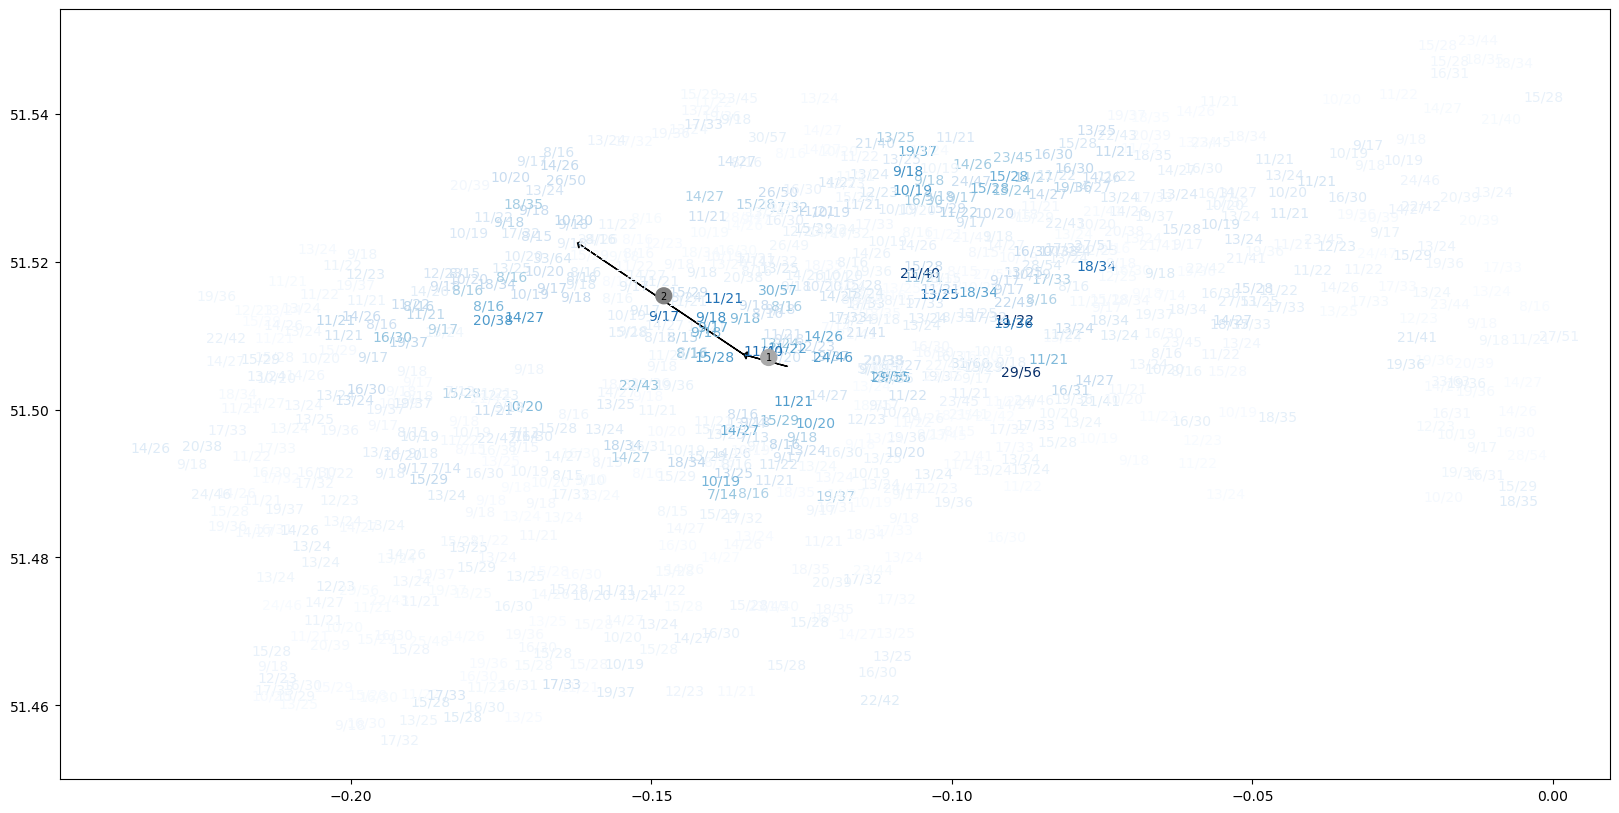

In [27]:
map_station_flux()
map_move_bike()

# Visualising the trips of the van. The light-grayed circles involve trips where the van is not carrying any bikes, while the dark-gray
# colour indicates the van is carrying and relocating the bikes.

In [28]:
((station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) | 
 (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)).any()

True

Available options:
╭────┬────────────┬────────────┬──────────────┬──────────────┬────────────┬──────────────┬──────────────┬────────────┬────────────┬─────────╮
│    │       p0p1 │    overall │ p1           │ p1           │         p1 │ p2           │ p2           │         p2 │       p1p2 │     num │
│    │   distance │   priority │ name         │ coordinate   │   priority │ name         │ coordinate   │   priority │   distance │   bikes │
├────┼────────────┼────────────┼──────────────┼──────────────┼────────────┼──────────────┼──────────────┼────────────┼────────────┼─────────┤
│  0 │  0.0356379 │   0.573754 │ Hop          │ POINT (-0.09 │   0.573754 │ Great Dover  │ POINT (-0.08 │  0.0404598 │ 0.00760955 │      10 │
│    │            │            │ Exchange,    │ 1773776      │            │ Street, The  │ 9446947      │            │            │         │
│    │            │            │ The Borough  │ 51.50462759) │            │ Borough      │ 51.49738251) │            │           

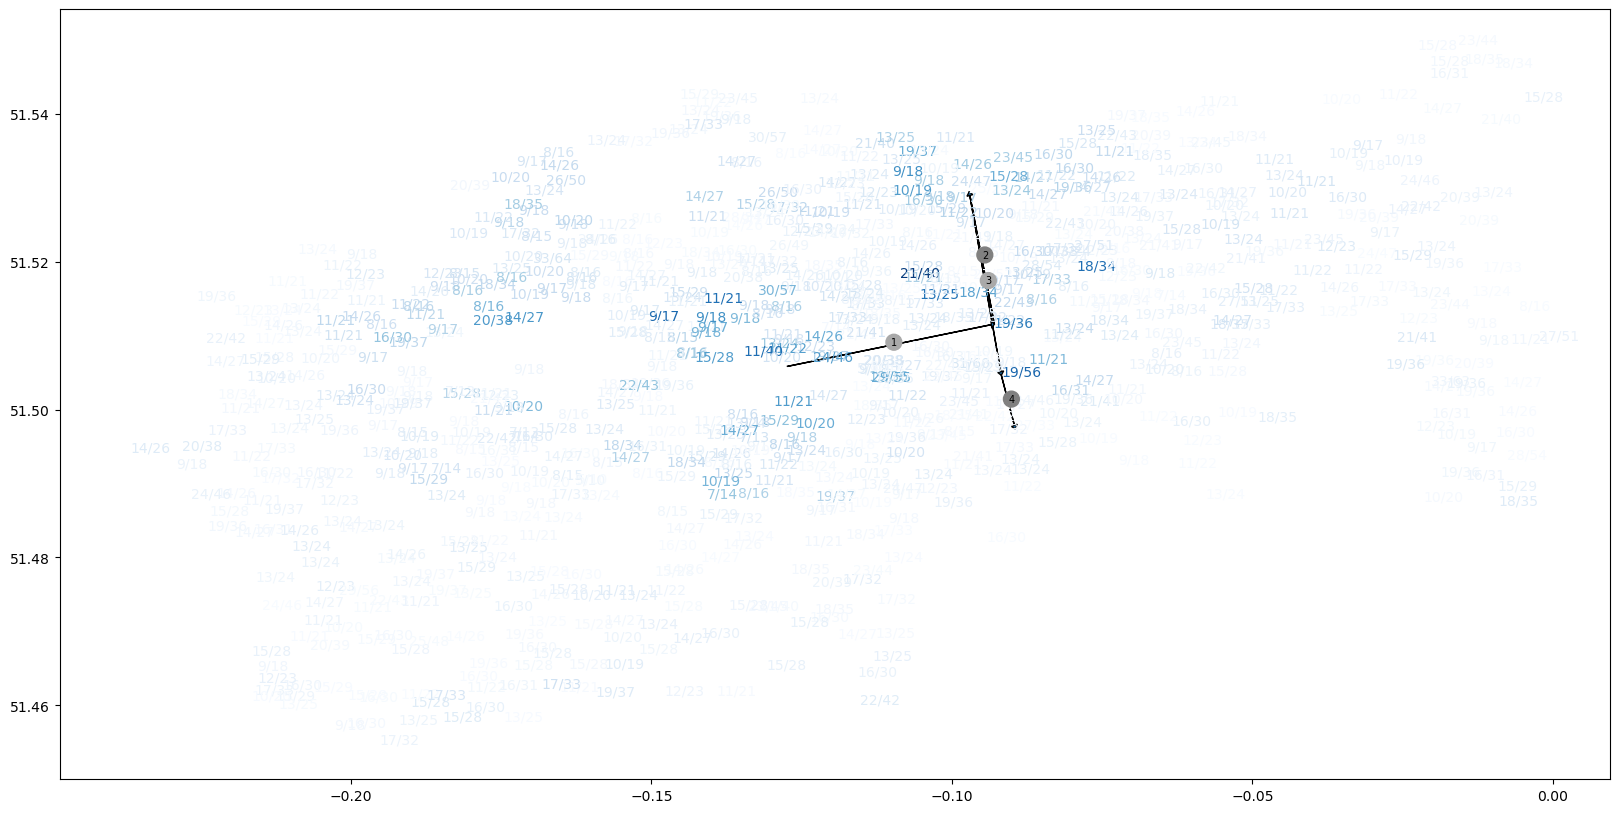

In [29]:
def move_bikes(p0, verbose=True):
    
    p0_name = 'Start point'
    p0_priority = 0

    relocation = pd.DataFrame(columns=['start_station_name', 'start_station_coordinate', 'start_station_priority',
                                       'end_station_name', 'end_station_coordinate', 'end_station_priority', 'distance', 'num_bikes',
                                       'x', 'y', 'dx', 'dy'])
        
    while ((station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) |
           (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)).any():

        p1_candidate = station_flux[(station_flux.bikes_count + station_flux.avg_chg_bicycles > station_flux.docks_count) | 
                                    (station_flux.bikes_count + station_flux.avg_chg_bicycles < 0)]

        option = pd.DataFrame(columns=['p0p1_distance', 'overall_priority', 'p1_name', 'p1_coordinate', 'p1_priority',
                                       'p2_name', 'p2_coordinate', 'p2_priority', 'p1p2_distance', 'num_bikes'])

        for p1_idx in p1_candidate.index:

            p1 = station_flux.loc[p1_idx, 'coordinate']

            if station_flux.loc[p1_idx, 'avg_chg_bicycles'] > 0:

                p2_candidate = station_flux[(station_flux.avg_chg_bicycles < 0) & (station_flux.docks_count - station_flux.bikes_count >= 10)]

                p2_priority =  0.521245 - (p2_candidate.bikes_count + p2_candidate.avg_chg_bicycles) / p2_candidate.docks_count
                    
                p1p2_distance = p1.distance(p2_candidate.coordinate)

                efficiency_min_sub = (p2_priority - p2_priority.min() + 1e-5) / (p1p2_distance ** 2 + 1e-5)

                p2_idx = efficiency_min_sub.idxmax()
                
                p2 = station_flux.loc[p2_idx, 'coordinate']

                p0p1_distance_val = p0.distance(p1)
                p1_name = station_flux.loc[p1_idx, 'station_name']
                p1_coordinate = p1
                p1_priority = station_flux.loc[p1_idx, 'priority']
                p2_name = station_flux.loc[p2_idx, 'station_name']
                p2_coordinate = p2
                p2_priority = station_flux.loc[p2_idx, 'priority']
                p1p2_distance_val = p1.distance(p2)
                overall_priority = p1_priority

            elif station_flux.loc[p1_idx, 'avg_chg_bicycles'] < 0:

                p2_candidate = station_flux[(station_flux.avg_chg_bicycles > 0) & (station_flux.bikes_count >= 10)]

                p2_priority = (p2_candidate.bikes_count + p2_candidate.avg_chg_bicycles) / p2_candidate.docks_count - 0.521245
                    
                p1p2_distance = p1.distance(p2_candidate.coordinate)

                efficiency_min_sub = (p2_priority - p2_priority.min() + 1e-5) / (p1p2_distance ** 2 + 1e-5)

                p2_idx = efficiency_min_sub.idxmax()

                p2 = station_flux.loc[p2_idx, 'coordinate']

                p0p1_distance_val = p0.distance(p2)
                p1_name = station_flux.loc[p2_idx, 'station_name']
                p1_coordinate = p2
                p1_priority = station_flux.loc[p2_idx, 'priority']
                p2_name = station_flux.loc[p1_idx, 'station_name']
                p2_coordinate = p1
                p2_priority = station_flux.loc[p1_idx, 'priority']
                p1p2_distance_val = p2.distance(p1)
                overall_priority = p2_priority          

            option.loc[len(option)] = [p0p1_distance_val, overall_priority, p1_name, p1_coordinate, p1_priority,
                                    p2_name, p2_coordinate, p2_priority, p1p2_distance_val, 10]
            
        best_option_idx = option.p0p1_distance.idxmin()

        if verbose:
            print('Available options:')
            print(tabulate(option, headers=[column.replace('_', '\n') for column in option.columns.tolist()],
                        tablefmt='rounded_grid', maxcolwidths=12))
            print('Best option (based only on distance):')
            print(tabulate(option.loc[[best_option_idx]], headers=[column.replace('_', '\n') for column in option.columns.tolist()],
                                    tablefmt='rounded_grid', maxcolwidths=12))
        
        start_station_name = p0_name
        start_station_coordinate = p0
        start_station_priority = p0_priority
        end_station_name = option.loc[best_option_idx, 'p1_name']
        end_station_coordinate = option.loc[best_option_idx, 'p1_coordinate']
        end_station_priority = option.loc[best_option_idx, 'p1_priority']
        distance = option.loc[best_option_idx, 'p0p1_distance']
        num_bikes = 0
        x = start_station_coordinate.x
        y = start_station_coordinate.y
        dx = end_station_coordinate.x - x
        dy = end_station_coordinate.y - y

        relocation.loc[len(relocation)] = [start_station_name, start_station_coordinate, start_station_priority,
                                           end_station_name, end_station_coordinate, end_station_priority, distance, num_bikes,
                                           x, y, dx, dy]

        start_station_name = option.loc[best_option_idx, 'p1_name']
        start_station_coordinate = option.loc[best_option_idx, 'p1_coordinate']
        start_station_priority = option.loc[best_option_idx, 'p1_priority']
        end_station_name = option.loc[best_option_idx, 'p2_name']
        end_station_coordinate = option.loc[best_option_idx, 'p2_coordinate']
        end_station_priority = option.loc[best_option_idx, 'p2_priority']
        distance = option.loc[best_option_idx, 'p1p2_distance']
        num_bikes = 10
        x = start_station_coordinate.x
        y = start_station_coordinate.y
        dx = end_station_coordinate.x - x
        dy = end_station_coordinate.y - y

        relocation.loc[len(relocation)] = [start_station_name, start_station_coordinate, start_station_priority,
                                           end_station_name, end_station_coordinate, end_station_priority, distance, num_bikes,
                                           x, y, dx, dy]
        
        if verbose:
            print('Before replacement:')
            print(tabulate(pd.concat([station_flux[station_flux.station_name == start_station_name],
                                      station_flux[station_flux.station_name == end_station_name]]), headers='keys',
                           tablefmt='rounded_grid', maxcolwidths=14))

        station_flux.loc[station_flux.station_name == start_station_name, 'bikes_count'] -= 10
        station_flux.loc[station_flux.station_name == end_station_name, 'bikes_count'] += 10
        priority_calc()

        if verbose:
            print('After replacement:')
            print(tabulate(pd.concat([station_flux[station_flux.station_name == start_station_name],
                                      station_flux[station_flux.station_name == end_station_name]]), headers='keys',
                           tablefmt='rounded_grid', maxcolwidths=14))
        
        p0_idx = station_flux[station_flux.station_name == option.loc[best_option_idx, 'p2_name']].index.values[0]
        
        p0_name = station_flux.loc[p0_idx, 'station_name']
        p0 = station_flux.loc[p0_idx, 'coordinate']
        p0_priority = station_flux.loc[p0_idx, 'priority']

    return relocation

relocation = move_bikes(Point(station_flux.longitude.mean(), station_flux.latitude.mean()))
map_station_flux()
map_move_bike()
        

In [30]:
relocation[relocation.columns[:-4]]

start_station_name                       start_station_coordinate  \
0                Start point  POINT (-0.1273914395784335 51.50582861818031)   
1       Queen Street 1, Bank                 POINT (-0.0929401 51.51155322)   
2  Macclesfield Rd, St Lukes                    POINT (-0.097122 51.529423)   
3  Hop Exchange, The Borough               POINT (-0.091773776 51.50462759)   

   start_station_priority                 end_station_name  \
0                0.000000             Queen Street 1, Bank   
1                0.541551        Macclesfield Rd, St Lukes   
2               -0.125445        Hop Exchange, The Borough   
3                0.573754  Great Dover Street, The Borough   

             end_station_coordinate  end_station_priority  distance  num_bikes  
0    POINT (-0.0929401 51.51155322)              0.541551  0.034924          0  
1       POINT (-0.097122 51.529423)              0.231697  0.018353         10  
2  POINT (-0.091773776 51.50462759)              0.573754  0.025366          0  
3  POINT (-0.089446947 51.49738251)              0.040460  0.007610         10

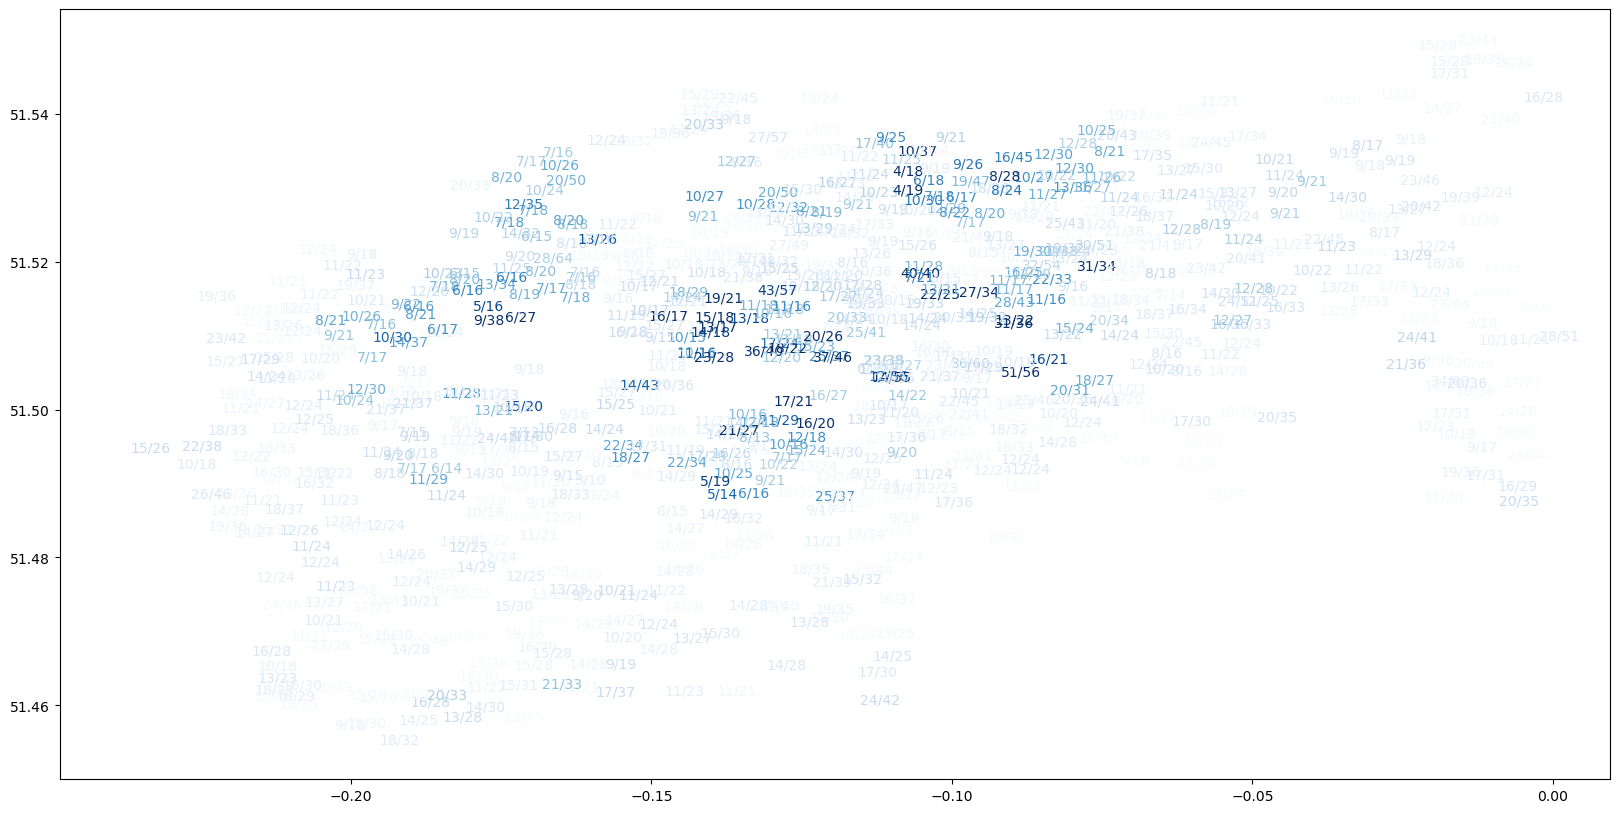

In [31]:
next_day()
map_station_flux()

Available options:
╭────┬────────────┬────────────┬──────────────┬──────────────┬────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────╮
│    │       p0p1 │    overall │ p1           │ p1           │         p1 │ p2           │ p2           │         p2 │        p1p2 │     num │
│    │   distance │   priority │ name         │ coordinate   │   priority │ name         │ coordinate   │   priority │    distance │   bikes │
├────┼────────────┼────────────┼──────────────┼──────────────┼────────────┼──────────────┼──────────────┼────────────┼─────────────┼─────────┤
│  0 │ 0.0083107  │   0.511081 │ Abingdon     │ POINT        │   0.511081 │ Waterloo     │ POINT        │   0.517753 │ 0.0140298   │      10 │
│    │            │            │ Green,       │ (-0.12597218 │            │ Station 2,   │ (-0.11342629 │            │             │         │
│    │            │            │ Westminster  │ 51.49764)    │            │ Waterloo     │ 51.50391973) │            │     

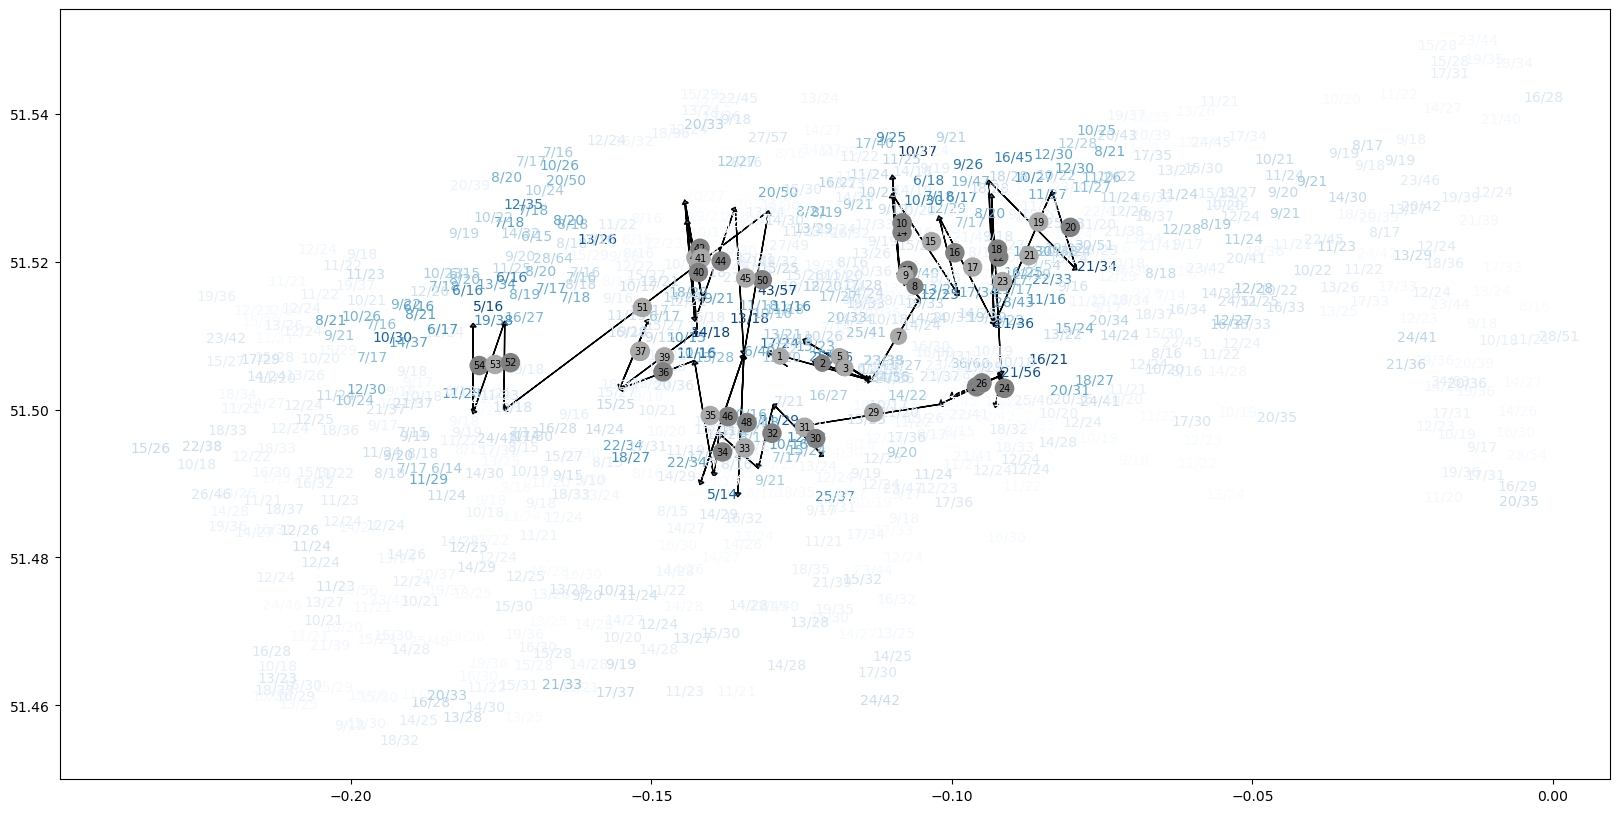

In [32]:
relocation = move_bikes(Point(station_flux.longitude.mean(), station_flux.latitude.mean()))
map_station_flux()
map_move_bike()

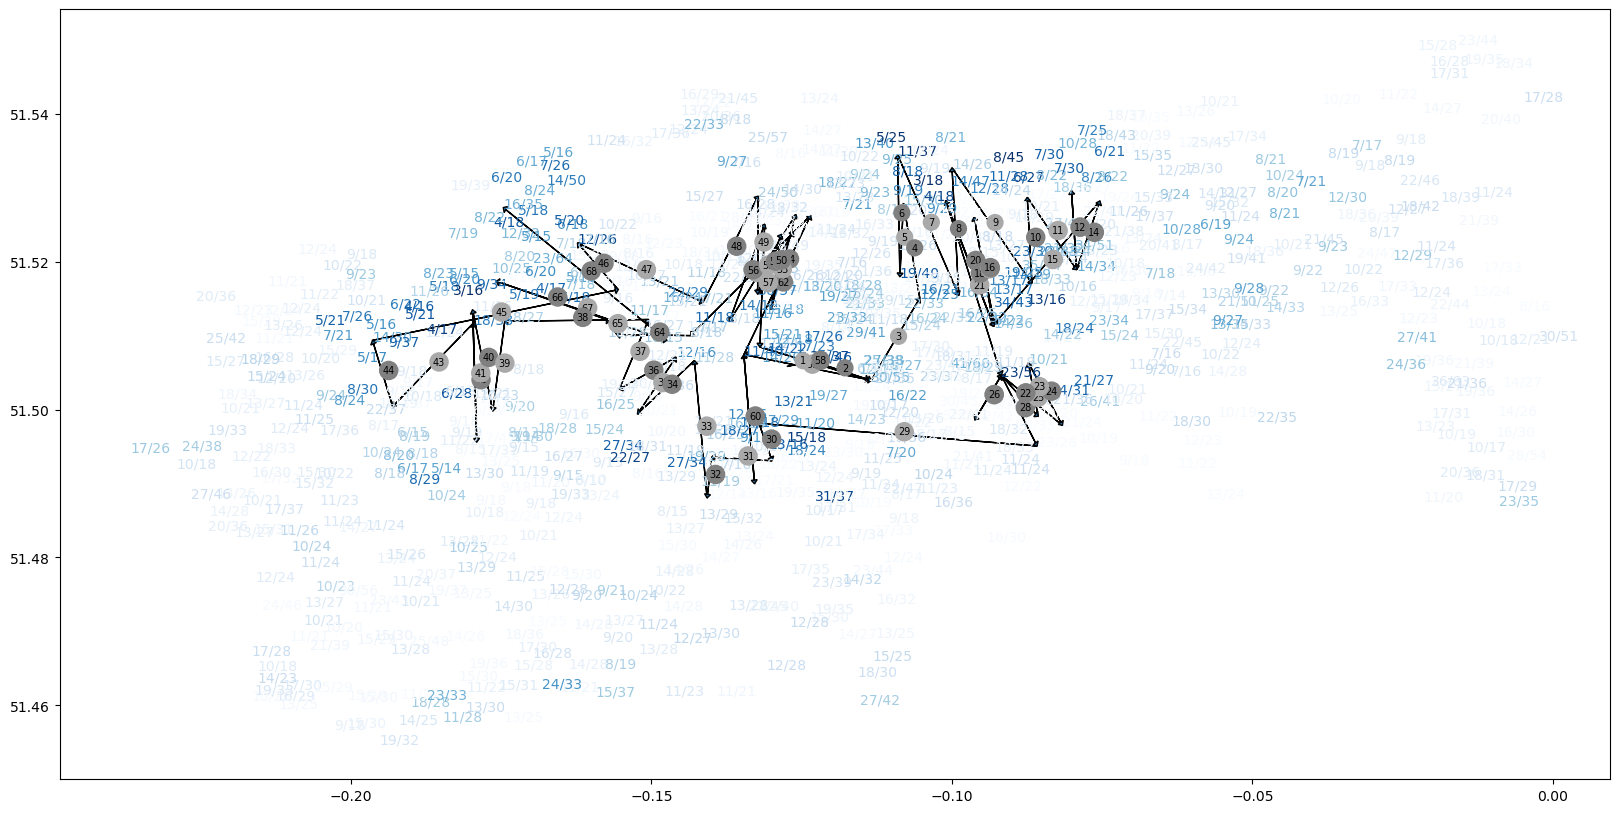

In [33]:
next_day()
relocation = move_bikes(Point(station_flux.longitude.mean(), station_flux.latitude.mean()), False)
map_station_flux()
map_move_bike()

Day 3!
Day 4!
Day 5!
Day 6!
Day 7!
Day 8!
Day 9!
Day 10!


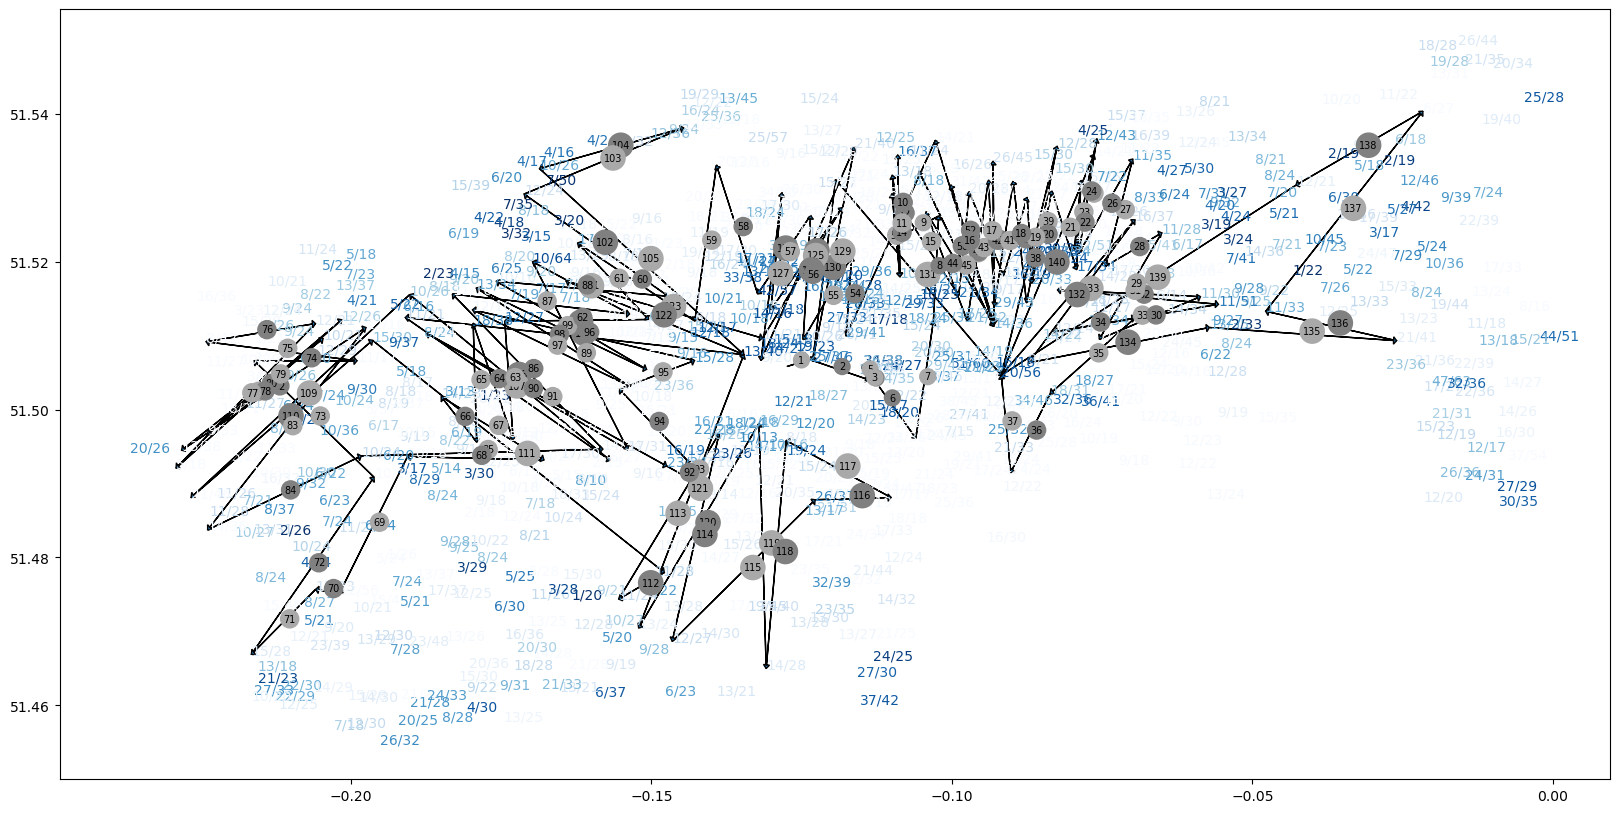

In [34]:
for i in range(3, 11):
    next_day()
    relocation = move_bikes(Point(station_flux.longitude.mean(), station_flux.latitude.mean()), False)
    print(f'Day {i}!')
map_station_flux()
map_move_bike()

# Example <a id='example-1'></a>

In [35]:
station_flux.drop(station_flux.index, inplace=True)
station_flux.head()

Empty DataFrame
Columns: [station_name, avg_chg_bicycles, latitude, longitude, bikes_count, docks_count, priority, day, coordinate]
Index: []

In [36]:
station_flux.loc[0] = ['A', -13, 0, 0, 10, 20, 0.521245 - (10 - 13) / 20, 0, Point(0, 0)]
station_flux.loc[1] = ['B', +13, 0, 0.04, 13, 25, (13 + 13) / 25 - 0.521245, 0, Point(0.04, 0)]
station_flux.loc[2] = ['C', +5, 0.02, 0, 15, 30, (15 + 5) / 30 - 0.521245, 0, Point(0, 0.02)]
station_flux.loc[3] = ['D', -5, 0.02, 0.04, 18, 35, 0.521245 - (18 - 5) / 35, 0, Point(0.04, 0.02)]

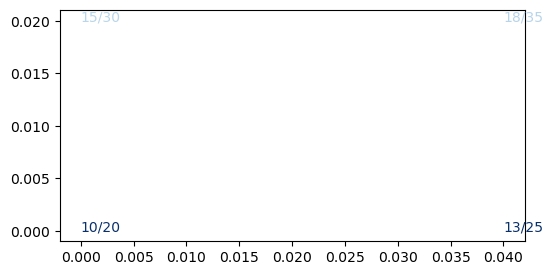

In [37]:
plt.rcParams['figure.figsize'] = [6, 3]

map_station_flux()

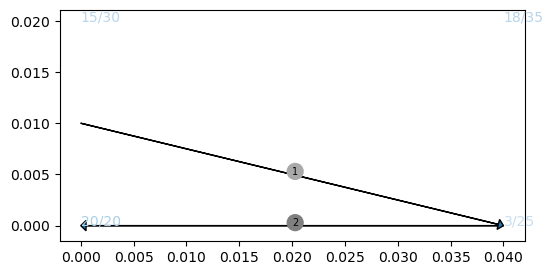

In [38]:
relocation = move_bikes(Point(0, 0.01), False)
map_station_flux()
map_move_bike()

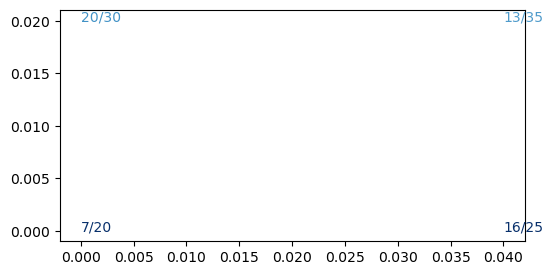

In [39]:
next_day()
map_station_flux()

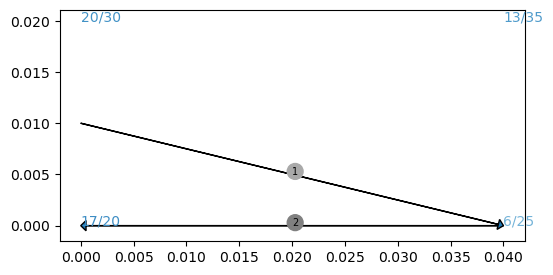

In [40]:
relocation = move_bikes(Point(0, 0.01), False)
map_station_flux()
map_move_bike()

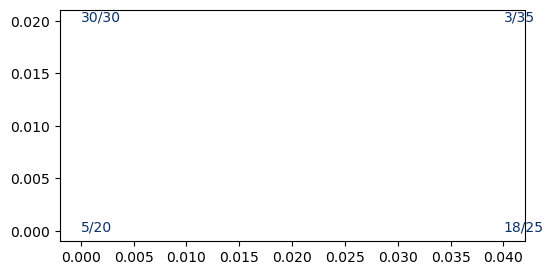

In [41]:
next_day()
relocation = move_bikes(Point(0, 0.01), False)
next_day()
relocation = move_bikes(Point(0, 0.01), False)
next_day()
relocation = move_bikes(Point(0, 0.01), False)
next_day()
map_station_flux()

Available options:
╭────┬────────────┬────────────┬────────┬──────────────┬────────────┬────────┬──────────────┬────────────┬────────────┬─────────╮
│    │       p0p1 │    overall │ p1     │ p1           │         p1 │ p2     │ p2           │         p2 │       p1p2 │     num │
│    │   distance │   priority │ name   │ coordinate   │   priority │ name   │ coordinate   │   priority │   distance │   bikes │
├────┼────────────┼────────────┼────────┼──────────────┼────────────┼────────┼──────────────┼────────────┼────────────┼─────────┤
│  0 │  0.0412311 │   0.921245 │ B      │ POINT (0.04  │   0.718755 │ A      │ POINT (0 0)  │   0.921245 │       0.04 │      10 │
│    │            │            │        │ 0)           │            │        │              │            │            │         │
├────┼────────────┼────────────┼────────┼──────────────┼────────────┼────────┼──────────────┼────────────┼────────────┼─────────┤
│  1 │  0.0412311 │   0.718755 │ B      │ POINT (0.04  │   0.718755 │ A

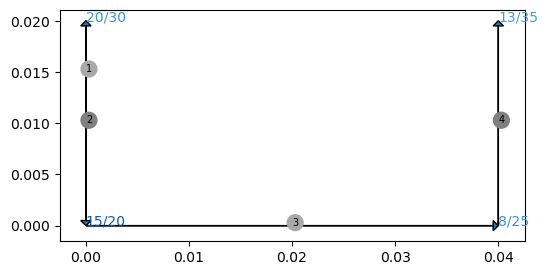

In [42]:
relocation = move_bikes(Point(0, 0.01), False)
map_station_flux()
map_move_bike()